MSDS 422 Assignment # 3 for James Benco

1: Importing Data amd Required Libraries

In [96]:
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [97]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
import category_encoders
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn import dummy
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


We will first import the data from the Digit Recognizer Dataset

In [98]:
#Train Data file
digitTrainDat = pd.read_csv("train.csv")
TrainDat = digitTrainDat.copy()

In [99]:
#Test Data File
digitTestDat = pd.read_csv("test.csv")
TestDat = digitTestDat.copy()

In [100]:
#Sample Submission File
digitSubFile = pd.read_csv("sample_submission.csv")

In [101]:
#Checking all the headers and datatypes of the training data
TrainDat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


All the data seems to be pixels which we will need to visualize to understand

2: Statistical EDA

<AxesSubplot:xlabel='label', ylabel='count'>

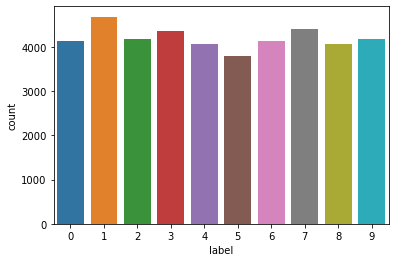

In [102]:
sns.countplot(data=TrainDat, x='label')

From this we can see that the dataset is comprised of visual pixelated images of the numbers 0-9.  All about similar distributions of the numbers with none being exactly equal to each other.

In [103]:
#first we will need to split into x and y train data
xTrain = TrainDat.drop(labels=['label'],axis=1)
yTrain = TrainDat['label']

We will now check for null values in the dataset

In [104]:
TrainDat.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

There seems to be no missing data for this dataset.

We will now perform PCA analysis on our imagedata

PCA(n_components=2)

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

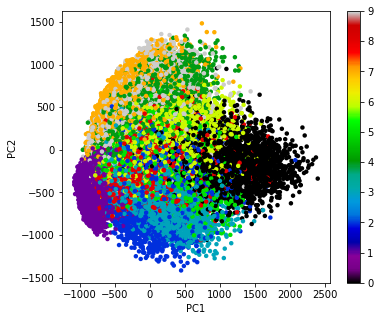

In [105]:
pca = PCA(n_components =2)
pca.fit(TrainDat)
transform = pca.transform(TrainDat)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c=yTrain, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()
clim(0,9)

xlabel("PC1")
ylabel("PC2")

The PCA above is for 2 components, it is interesting to note the clusters from just 2 components.  We will now increase the amount of components and see what the data shows.

In [106]:
#First we will create an array for the n_components to follow from a min of 1 to a max of the dataset 784
n_components_array = ([1,2,3,4,5,10,20,50,100,200,500,784])
nCompLen = np.zeros(len(n_components_array))
i=0;
#now we will loop to perform PCA analysis for each length of n_components and then below plot the variance to determine the best value
for n_components in n_components_array:
    pca=PCA(n_components=n_components)
    pca.fit(xTrain)
    nCompLen[i]=sum(pca.explained_variance_ratio_)
    i+=1

PCA(n_components=1)

PCA(n_components=2)

PCA(n_components=3)

PCA(n_components=4)

PCA(n_components=5)

PCA(n_components=10)

PCA(n_components=20)

PCA(n_components=50)

PCA(n_components=100)

PCA(n_components=200)

PCA(n_components=500)

PCA(n_components=784)

<Figure size 576x288 with 0 Axes>

(0.09, 1.0)

([<matplotlib.axis.YTick at 0x13261489d60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(0.9, 1094.0366369077378)

Text(0.5, 0, 'Number of PCA components')

Text(0, 0.5, 'Variance Ratio')

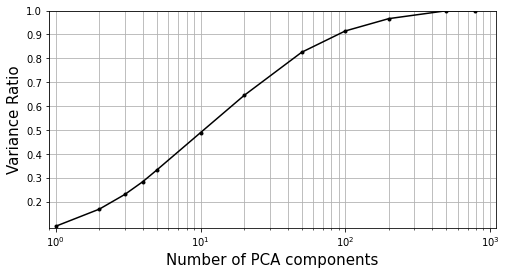

In [107]:
#Plotting the variance ratio determined from the loop above
figure(figsize(8,4))
plot(n_components_array, nCompLen,'k.-')
xscale("log")
ylim(9e-2,1,1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("Number of PCA components", size =15)
ylabel("Variance Ratio", size =15)

The number of components necessary to account for at least 75% of the variance would be about 35 components, and for the 85% benchmark we would need approximately at least 70 components.  I will choose a value that covers about 90% as that value is 100 components.

3: Model Creation

In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier


In [109]:
#Need to import some more necessary libraries for k-fold and cross validation
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

Model: Random Forest

In [110]:
pca = PCA(n_components=100)
pca.fit(xTrain)
transXTrain = pca.transform(xTrain)
transTest = pca.transform(TestDat)

model = RandomForestClassifier()
model.fit(transXTrain,yTrain)
results = model.predict(transTest)


PCA(n_components=100)

RandomForestClassifier()

In [111]:
print('             Random Forest            ')
print('RF Accuracy is: ', round(accuracy_score(yTrain, model.predict(transXTrain))*100,2))
#Now to Kfold the data into 10 equal sections
kfold = KFold(n_splits =8, shuffle = True, random_state =42)


             Random Forest            
RF Accuracy is:  100.0


Seems as if our Random Forest model is overfitted to our training data.

4: HyperParameter Tuning

Hypertuning Random Forest Model

In [112]:
#Generating our initial model to tune our hyperparameters
model = RandomForestClassifier(random_state=42, n_jobs=1)

#Number of trees in the forest
n_estimators = [1,10,20,30,50,100,200]
#Number of features to consider every split
max_features = [2,3,4]
#Maximum number of levels in the tree
max_depth = [1,2,5,10,20,50]
#Minimum number of samples per leaf in each tree
min_samples_leaf=[5,10,20,50,100]


paramGrid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf
}

gridsearchRF = GridSearchCV(estimator=model, param_grid =paramGrid, cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
#finding the best score with the best parameters
gridsearchRF.fit(transXTrain, yTrain)
print(gridsearchRF.best_score_)
#best estimation
rfBest = gridsearchRF.best_estimator_
rfBest

Fitting 4 folds for each of 630 candidates, totalling 2520 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20, 50],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [1, 10, 20, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

0.9386428571428571


RandomForestClassifier(max_depth=20, max_features=4, min_samples_leaf=5,
                       n_estimators=200, n_jobs=1, random_state=42)

In [113]:
#Applying our best parameters to our delivered model
rfModel = RandomForestClassifier(max_depth = 50, max_features =4, min_samples_leaf=5, n_estimators=200, n_jobs=1,random_state=42)
rfModel.fit(transXTrain,yTrain)


RandomForestClassifier(max_depth=50, max_features=4, min_samples_leaf=5,
                       n_estimators=200, n_jobs=1, random_state=42)

5: Test Data and Submission

In [114]:
result = rfModel.predict(transTest)
result = pd.Series(result,name='Label')

In [115]:
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),result],axis=1)

In [116]:
submission.to_csv('Submission.csv', index = False)

6: K-Mean Clustering

In [117]:
#Importing the necessary libraries
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import MiniBatchKMeans

In [118]:
#Converting each image to a 1D array
xTrainNP = xTrain.to_numpy()
yTrainNP = yTrain.to_numpy()

In [119]:
#Converting the image to a 1d Array
x_train = xTrainNP.reshape(len(xTrainNP),-1)
y_train = yTrainNP.reshape(len(yTrainNP),-1)
print(x_train.shape)
print(y_train.shape)

(42000, 784)
(42000, 1)


In [120]:
#applying K Means Clustering

n_digits = len(np.unique(yTrain))
print(n_digits)

10


In [121]:
kmeans = MiniBatchKMeans(n_clusters = n_digits)
kmeans.fit(x_train)

C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=10)

In [122]:
#checking labels to confirm images are labeled with their corresponding groups
kmeans.labels_


array([3, 8, 4, ..., 6, 0, 6])

In [123]:
#Need to convert to make sure labels correspond with the correct groupings
#Will define a function to perform this action
def clusterLabels(kmeans, actual_labels):
    infer_labels={}
    #Loop through our generated clusters
    for i in range(kmeans.n_clusters):
        #index our clusters
        labels=[]
        index = np.where(kmeans.labels_ == i)
        
        #append our actual labels for each image in cluster
        labels.append(actual_labels[index])
        
        #Find most common label
        if len(labels[0]) ==1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
            
        #Assign cluster value to our inferred labels dict
        if np.argmax(counts) in infer_labels:
            infer_labels[np.argmax(counts)].append(i)
        else:
            infer_labels[np.argmax(counts)] = [i]
            
    return infer_labels

In [124]:
def dataLabels(x_labels, clusterLabels):
    predLabels = np.zeros(len(x_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(x_labels):
        for key, value in clusterLabels.items():
            if cluster in value:
                predLabels[i]=key
    return predLabels

In [125]:
#applying our defined functions above
ClusterLabels = clusterLabels(kmeans,y_train)
xClusters = kmeans.predict(x_train)
#Comparing our inferred labels to the actual valued labels
PredLabels = dataLabels(xClusters, ClusterLabels)
print(PredLabels[:20])
print(yTrain[:20])

[1 0 1 4 0 9 9 3 3 3 8 7 1 3 3 1 8 0 7 6]
0     1
1     0
2     1
3     4
4     0
5     0
6     7
7     3
8     5
9     3
10    8
11    9
12    1
13    3
14    3
15    1
16    2
17    0
18    7
19    5
Name: label, dtype: int64


Although Inverted, the y_train values are inverted, the columns generally match the inferred labels for each grouping in out KMeans groupings.  We can now start evaluating our KMeans clustering.

7: Evaluating KMeans Clustering

In [126]:
#Importing the necessary libraries
from sklearn.metrics import homogeneity_score
#Creating a function to generate Inertia and Homogeneity Scores
def metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    #Inertia Score
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    #Homogeniety Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity Score: {}".format(homogeneity))
    
    return inertia, homogeneity
    
    
    

In [127]:
#Importing Accuracy Score
from sklearn.metrics import accuracy_score

clusters = [10,16,36,64,144,256]
inertia_list = []
homogeneity_list = []
accuracy_list =[]

#Creating a Loop to apply our metrics to our data

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(x_train)
    
    #Applying Inertia Metrics
    inertia,homogeneity = metrics(estimator, x_train, yTrain)
    inertia_list.append(inertia)
    homogeneity_list.append(homogeneity)
    
    #Determine our Predicted Labels
    cluster_labels = clusterLabels(estimator, y_train)
    prediction = dataLabels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    accuracy_list.append(acc)
    print("Accuracy: {}\n".format(acc))

C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=10)

Number of Clusters: 10
Inertia: 109699545949.93161
Homogeneity Score: 0.4349572183295776
Accuracy: 0.538547619047619



C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=16)

Number of Clusters: 16
Inertia: 101341683817.12744
Homogeneity Score: 0.5453246456945526
Accuracy: 0.6293571428571428



C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=36)

Number of Clusters: 36
Inertia: 94306348237.0105
Homogeneity Score: 0.6352019665644852
Accuracy: 0.7324285714285714



C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=64)

Number of Clusters: 64
Inertia: 82512803494.59268
Homogeneity Score: 0.7502947885226294
Accuracy: 0.8305



C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=144)

Number of Clusters: 144
Inertia: 74080555534.16933
Homogeneity Score: 0.8027511470858176
Accuracy: 0.864452380952381



C:\Users\PAIN IN MY ASS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=256)

Number of Clusters: 256
Inertia: 69039667667.06644
Homogeneity Score: 0.8349820973446904
Accuracy: 0.8866428571428572



Plotting our Inertia, Homogeneity, and Accuracy Scores

Text(0.5, 1.0, 'Inertia Value of each Cluster')

Text(0.5, 1.0, 'Homogeneity and Accuracy Scores of each Cluster')

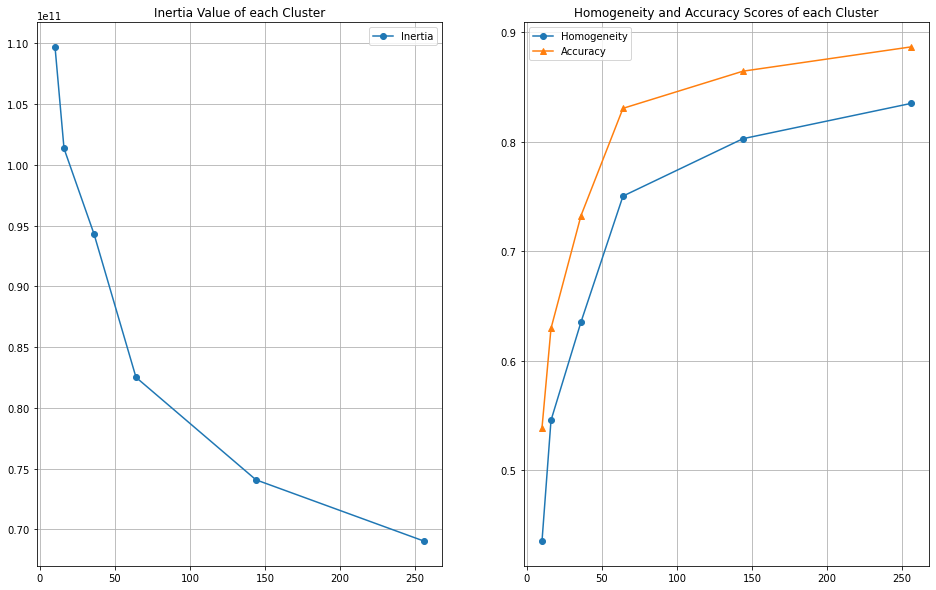

In [128]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].plot(clusters, inertia_list, label='Inertia', marker='o')
ax[1].plot(clusters, homogeneity_list, label='Homogeneity', marker='o')
ax[1].plot(clusters, accuracy_list, label ='Accuracy', marker='^')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

ax[0].grid('on')
ax[1].grid('on')

ax[0].set_title("Inertia Value of each Cluster")
ax[1].set_title("Homogeneity and Accuracy Scores of each Cluster")
plt.show()

We can see that our accuracy and Homogeneity increased as our k values increased.  We have the inverse relationship with our Inertia value.

8: Comparing K Means Clustering to our Random Forest Model

In [129]:
print("Random Forest Model Accuracy Score: ", gridsearchRF.best_score_)
print("Best K Means Clustering Accuracy Score: ", max(accuracy_list))

Random Forest Model Accuracy Score:  0.9386428571428571
Best K Means Clustering Accuracy Score:  0.8866428571428572


We can see that our Random Forest Model had the best accuracy score for our training data.  This is a good thing, however, still can be indicative of an overfit model. Both were close in accuracy.